# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>

# MLP的简单实现

In [2]:
/*design a net*/
struct Net : torch::nn::Module {
  Net() {
    // Construct and register two Linear submodules.
    fc1 = register_module("fc1", torch::nn::Linear(784, 256));
    fc2 = register_module("fc2", torch::nn::Linear(256, 10));
  }

  // Implement the Net's algorithm.
  torch::Tensor forward(torch::Tensor x) {
    // Use one of many tensor manipulation functions.
    x = fc1->forward(x.reshape({x.size(0), 784}));
    x = torch::relu(x);
    x = fc2->forward(x);
    x = torch::log_softmax(x, /*dim=*/1);      
    return x;
  }

  // Use one of many "standard library" modules.
  torch::nn::Linear fc1{nullptr}, fc2{nullptr};
};

In [3]:
constexpr int MAX_EPOCH = 50;
constexpr float lr = 0.01;


// Create a new Net.
auto net = std::make_shared<Net>();

// Create a multi-threaded data loader for the MNIST dataset.
auto data_loader = torch::data::make_data_loader(
  torch::data::datasets::MNIST("../dataset/fashion_mnist").map(
      torch::data::transforms::Stack<>()),
  /*batch_size=*/100);

// Instantiate an SGD optimization algorithm to update our Net's parameters.
torch::optim::SGD optimizer(net->parameters(), lr);

for (size_t epoch = 1; epoch <= MAX_EPOCH; ++epoch) {
    size_t batch_index = 0;
    // Iterate the data loader to yield batches from the dataset.
    for (auto& batch : *data_loader) {
        // Reset gradients.
        optimizer.zero_grad();
        // Execute the model on the input data.
        torch::Tensor prediction = net->forward(batch.data);
        // Compute a loss value to judge the prediction of our model.
        torch::Tensor loss = torch::nll_loss(prediction, batch.target);
        // Compute gradients of the loss w.r.t. the parameters of our model.
        loss.backward();
        // Update the parameters based on the calculated gradients.
        optimizer.step();
        // Output the loss and checkpoint every 100 batches.
        if (++batch_index % 300 == 0) {
        std::cout << "Epoch: " << epoch << " | Batch: " << batch_index
                  << " | Loss: " << loss.item<float>() << std::endl;
        // Serialize your model periodically as a checkpoint.
//         torch::save(net, "net.pt");
        }
    }    
}

std::cout << std::endl << "\r\nTraining finished!\r\n" << std::endl;

Epoch: 1 | Batch: 300 | Loss: 1.10474
Epoch: 1 | Batch: 600 | Loss: 0.912615
Epoch: 2 | Batch: 300 | Loss: 0.613811
Epoch: 2 | Batch: 600 | Loss: 0.654632
Epoch: 3 | Batch: 300 | Loss: 0.847653
Epoch: 3 | Batch: 600 | Loss: 0.614744
Epoch: 4 | Batch: 300 | Loss: 0.84523
Epoch: 4 | Batch: 600 | Loss: 0.553042
Epoch: 5 | Batch: 300 | Loss: 0.50634
Epoch: 5 | Batch: 600 | Loss: 0.615234
Epoch: 6 | Batch: 300 | Loss: 0.524782
Epoch: 6 | Batch: 600 | Loss: 0.63913
Epoch: 7 | Batch: 300 | Loss: 0.491896
Epoch: 7 | Batch: 600 | Loss: 0.49969
Epoch: 8 | Batch: 300 | Loss: 0.368126
Epoch: 8 | Batch: 600 | Loss: 0.424562
Epoch: 9 | Batch: 300 | Loss: 0.509481
Epoch: 9 | Batch: 600 | Loss: 0.414109
Epoch: 10 | Batch: 300 | Loss: 0.468134
Epoch: 10 | Batch: 600 | Loss: 0.566764
Epoch: 11 | Batch: 300 | Loss: 0.528143
Epoch: 11 | Batch: 600 | Loss: 0.424017
Epoch: 12 | Batch: 300 | Loss: 0.463069
Epoch: 12 | Batch: 600 | Loss: 0.358663
Epoch: 13 | Batch: 300 | Loss: 0.409837
Epoch: 13 | Batch: 600 

In [4]:
void show_images(std::vector<torch::Tensor> images, std::vector<torch::Tensor> labels, std::string labeltxt[])
{
    auto a = images;
    auto b = labels;

    torch::Tensor image1, image2, label;
    std::string s1, s2;
    for (int i = 0; i < a.size()/2; i++) {
        torch::Tensor t1 = a[i].squeeze();
        torch::Tensor t2 = a[i+1].squeeze();
        if (image1.numel() == 0) {
            image1 = t1.clone();
            s1 = labeltxt[b[i].item<int>()] + "\t\t";
        } else {
            image1 = torch::cat({image1, t1}, 1);
            s1 += labeltxt[b[i].item<int>()];
            s1 += "\t\t";
        }

        if (image2.numel() == 0) {
            image2 = t2.clone();
            s2 = labeltxt[b[i+1].item<int>()] + "\t\t";
        } else {
            image2 = torch::cat({image2, t2}, 1);
            s2 += labeltxt[b[i+1].item<int>()];
            s2 += "\t\t";
        }
    }
       
    std::cout << s1 << std::endl;
    std::cout << s2 << std::endl;
    torch::Tensor image = torch::cat({image1, image2}, 0);
    image *= 255;
    image = torch::clamp(image, 0, 255);
    // 原数据类型为float，为适应cv Mat的数据类型（CV_8UC1），需要转换为unsigned char;
    image = image.to(torch::kU8);
    cv::Mat img(image.size(0), image.size(1), CV_8UC1);
    std::memcpy((void*)img.data, image.data_ptr(), sizeof(torch::kU8)*image.numel());
    cv::imwrite("test.png", img);
}

In [5]:
std::string text_labels[10] = { "t-shirt", "trouser", 
                                "pullover", "dress", 
                                "coat", "sandal", 
                                "shirt", "sneaker", 
                                "bag", "ankle boot"
                               };

auto data_loader_test = torch::data::make_data_loader(
  torch::data::datasets::MNIST("../dataset/fashion_mnist").map(
      torch::data::transforms::Stack<>()),
  /*batch_size=*/12);

auto batch_iter = data_loader_test->begin();
auto images0 = (*batch_iter).data;
auto labels0 = (*batch_iter).target;

/*看一下每个batch的大小*/
printT(images0.sizes());
printT(labels0.sizes());

images0.sizes() = 
[12, 1, 28, 28]
<<--->>

labels0.sizes() = 
[12]
<<--->>



pullover		coat		dress		pullover		bag		coat		
coat		dress		pullover		bag		coat		t-shirt		


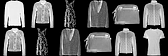

In [6]:
/* **
 * images0是batch tensor，是一个四维tensor，其大小为batch_size x channel x height x width
 * 使用chunk()将其拆散为batch_size个独立tensor，每个tensor是一幅独立图片，然后将这些tensor再组合
 * 成一个vector<torch::Tensor>;
 */
auto a = torch::chunk(images0, images0.size(0));
auto b = torch::chunk(labels0, labels0.size(0));

// 取出其中第一幅图像，其大小为 1 x 28 x 28，其中1是通道数
auto image = a[0].clone();
auto label = b[0].clone();

// printT(image.sizes());
// 使用squeeze()去除那些大小为1的维度，这里，会把图片的通道维度消除掉，仅剩下长、宽；
// permute()函数用于交换不同维度的顺序，这里用不到，如果是3通道图像，tensor的格式为
// C X H X W，此时需要借助permute()将其变为 H X W X C;
image = image.squeeze();//.permute({1,2,0});
// 因为在处理前对cvmat中的值做了归一化，所以现在要*255恢复，同时对于不在0-255范围内的数据，需要做限制
image *= 255;
image = torch::clamp(image, 0, 255);
// 原数据类型为float，为适应cv Mat的数据类型（CV_8UC1），需要转换为unsigned char;
image = image.to(torch::kU8);

// printT(image);
show_images(a, b, text_labels);
auto simg = im::image("test.png");
simg

pullover		coat		dress		pullover		bag		coat		
coat		dress		pullover		bag		coat		t-shirt		


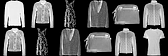

In [7]:
auto result = net->forward(images0);
auto tt = result.max(1);
auto aa = std::get<0>(tt);
auto bb = std::get<1>(tt); //index

// printT(aa.dim());
// printT(bb.dim());
// printT(aa);
// printT(bb);

auto c = torch::chunk(images0, images0.size(0));
auto d = torch::chunk(bb, bb.size(0));
show_images(c, d, text_labels);
auto simg = im::image("test.png");
simg

/* 
 * 经过30个轮次的训练，识别结果还是有个别错误
 */